# Replicate pocket-level-evaluation.ipynb
We need to create a plot where we will compare DCC and cluster fragmentation.

Especially, we need to run the atom-level clustering and subsequently the smoothing.

Let's run it on LIGYSIS, as the flexible nature of CBSs might be problematic.

In [ ]:
from transformers import AutoTokenizer
import torch
import numpy as np
import functools
from sklearn import metrics
from torch.utils.data import DataLoader
import sys

sys.path.append('/home/skrhakv/cryptoshow-analysis/src/B-evaluate-cryptoshow')
sys.path.append('/home/skrhakv/cryptic-nn/src')
import finetuning_utils
from finetuning_utils import FinetunedEsmModel
import eval_utils
from eval_utils import CryptoBenchClassifier
import cryptoshow_utils

MODEL_NAME = 'facebook/esm2_t36_3B_UR50D'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

MODEL_PATH = "/home/skrhakv/cryptic-nn/final-data/trained-models/multitask-finetuned-model-with-ligysis.pt"

SMOOTHING_MODEL_PATH = '/home/skrhakv/cryptoshow-analysis/data/C-optimize-smoother/smoother.pt'
smoothing_model = torch.load(SMOOTHING_MODEL_PATH, weights_only=False) #, map_location=torch.device('cpu'))

In [7]:
import sys
import numpy as np
from Bio.PDB import MMCIFParser
from Bio.PDB.SASA import ShrakeRupley
from sklearn.cluster import MeanShift, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.mixture import BayesianGaussianMixture
from collections import Counter

CIF_FILES = '/home/skrhakv/cryptoshow-analysis/data/F-clustering/cif_files'
EPS = 10
POINTS_DENSITY_PER_ATOM = 50
# VDW radius of Carbon + water probe radius
PROBE_RADIUS = 1.6

def execute_atom_clustering(pdb_id, chain_id, predictions, probabilities, eps=EPS):
    """
    Execute atom-level clustering based on predicted binding residues.
    Args:
        pdb_id: PDB identifier of the protein.
        chain_id: Chain identifier of the protein.
        predictions: List of predicted binding residue IDs (mmCIF numbering).
        probabilities: List of probabilities/scores for the predicted binding residues.
    Returns:
        clusters: Dict {cluster_id: [atom_id, ...], ...}
        cluster_residues: List of Lists [[residue_id, ...], ...] for each cluster. The ordering corresponds to cluster IDs.
        cluster_scores: List of average scores for each cluster. List has size of N, where N is number of clusters, and the ordering corresponds to cluster IDs.
        atom_coords: Dict {atom_id: np.array([x,y,z])}
    """
    # 1. Map mmCIF numbering to auth numbering
    auth_predictions, scores = cryptoshow_utils.map_mmcif_numbering_to_auth(pdb_id, chain_id, predictions, binding_scores=probabilities)

    # 2. Get surface points and their mapping to atoms, atom coordinates, and atom to residue mapping
    all_points, map_point_to_atom, map_atoms_to_residue_id, atom_coords, residue_coords = get_protein_surface_points(pdb_id, chain_id, auth_predictions)

    if all_points.shape[0] == 0:
        return None, None, None, None, None

    # 3. Cluster surface points and propagate labels to atoms    
    atom_labels = cluster_atoms_by_surface(
        all_points, map_point_to_atom, eps=eps)
    
    # get cluster dictionary {cluster_id: [atom_id, ...], ...}
    clusters = {}
    for atom_index, cluster_label in atom_labels.items():
        if cluster_label not in clusters:
            clusters[cluster_label] = []
        clusters[cluster_label].append(atom_index)

    # 4. Voting: the residue gets the label of the majority of its atoms
    cluster_scores = [[] for _ in range(max(clusters) + 1)]
    cluster_residues = [[] for _ in range(max(clusters) + 1)]
    auth_predictions = np.array(auth_predictions)
    
    # 4.1 For each atom in each cluster, get its residue and score
    for atom_id, cluster_label in atom_labels.items():
        residue_id = map_atoms_to_residue_id[atom_id] # this is auth residue id
        score = scores[np.where(auth_predictions == int(residue_id))[0][0]]
        cluster_scores[cluster_label].append(score)
        cluster_residues[cluster_label].append(residue_id)
    
    # 4.2 Vote
    residue_voting = {residue: [0 for _ in range(len(cluster_residues))] for residue in auth_predictions}
    for i, labels in enumerate(cluster_residues):
        counts = Counter(labels)
        for residue, number_of_occurences in counts.items():
            residue_voting[residue][i] = number_of_occurences
    
    residue_clusters = {i: [] for i in range(len(cluster_residues))}
    # 4.3 get residue cluster assignment based on voting
    for residue, votes in residue_voting.items():
        cluster = np.argmax(votes)
        residue_clusters[cluster].append(residue)

    # 5. Compute average cluster scores
    final_cluster_scores = []
    for scores in cluster_scores:
        if len(scores) == 0:
            final_cluster_scores.append(0.0)
        else:
            final_cluster_scores.append(np.mean(scores))
    cluster_scores = final_cluster_scores

    return clusters, residue_clusters, cluster_scores, atom_coords, residue_coords


def cluster_atoms_by_surface(all_points, point_to_atom_map, eps=1.5, gmm=False):
    """
    Clusters surface points and propagates labels to atoms via majority vote.
    
    Args:
        surface_points_dict: Dict {atom_id: np.array([[x,y,z], ...])}
        eps: DBSCAN maximum distance between two samples (in Angstroms).
        min_samples: DBSCAN minimum samples in a neighborhood for a core point.
        
    Returns:
        atom_labels: Dict {atom_id: cluster_label_int}
        point_labels: Array of labels for the flattened points (for visualization)
        all_points: Array of coordinates (for visualization)
    """
    
    if not gmm:
        # n_jobs=-1 uses all CPU cores.
        # clustering = AffinityPropagation(damping=0.9, preference=-200, max_iter=500, convergence_iter=50)
        clustering = MeanShift(bandwidth=eps, bin_seeding=True, n_jobs=-1) # eps = 9 or 12 pls, less is baaaad
        # clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=eps, linkage='ward') 
        # clustering = DBSCAN(eps=eps, min_samples=5)
        # clustering = DBSCAN(eps=6, min_samples=1)

        clustering.fit(all_points)
        point_labels = clustering.labels_

    if gmm:
        # get the optimal number of components
        bgmm = BayesianGaussianMixture(
            n_components=max(len(all_points), 1) - 1, 
            random_state=42,
            covariance_type='spherical',
        )

        bgmm.fit(all_points)

        active_clusters = sum(bgmm.weights_ > 0.1) # Check how many clusters are actually used - how many are composed of >10% of points
        clustering = BayesianGaussianMixture(
            n_components=max(active_clusters, 1), 
            random_state=42,
            covariance_type='spherical',
        )

        point_labels = clustering.fit_predict(all_points)
    
    # Majority Vote (Propagate to Atoms)
    atom_labels = {}
    
    # Get unique atom IDs present in the data
    unique_atoms = np.unique(point_to_atom_map)
    
    for atom_id in unique_atoms:
        # 1. Find indices in the master array belonging to this atom
        indices = np.where(point_to_atom_map == atom_id)[0]
        
        # 2. Extract the cluster labels for these points
        current_labels = point_labels[indices]
        
        # 3. Determine the most common label (majority vote)
        counts = Counter(current_labels)
        majority_label = counts.most_common(1)[0][0]
        atom_labels[atom_id] = majority_label

    return atom_labels

aal_prot = {
    "ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY", "HIS", "ILE", 
    "LEU", "LYS", "MET", "PHE", "PRO", "SER", "THR", "TRP", "TYR", "VAL",
    "ASH", "GLH", "HIE", "HID", "HIP", "LYN", "CYX", "CYM", "TYM"
}
# Keeps only standard protein residues in the structure
def keep_only_protein(structure):
    """Keep only standard protein residues in the structure."""
    for residue in list(structure):
        if residue.get_resname() not in aal_prot:
            structure.detach_child(residue.id)
    return structure

def get_protein_surface_points(pdb_id, chain_id, predicted_binding_sites):
    p = MMCIFParser(QUIET=1)
    struct = p.get_structure("protein", f"{CIF_FILES}/{pdb_id}.cif")
    struct = struct[0][chain_id]  # Get first model, chain A
    struct = keep_only_protein(struct)

    # compute SASA
    sr = ShrakeRupley(n_points=POINTS_DENSITY_PER_ATOM, probe_radius=PROBE_RADIUS)
    sr.compute(struct, level="A")

    surface_points = []
    map_surface_points_to_atom_id = []
    atom_coords = {}
    residue_coords = {}
    map_atoms_to_residue_id = {}
    for residue in struct.get_residues():
        # consider only residues from predicted binding sites
        residue_id = residue.get_id()[1]
        
        if 'CA' in residue:
            residue_coords[residue_id] = residue['CA'].get_vector()
        else:
            # if no CA atom, use the first atom's coordinates
            first_atom = next(residue.get_atoms())
            residue_coords[residue_id] = first_atom.get_vector()
        
        if residue.get_id()[1] not in predicted_binding_sites:
            continue
        
        # get surface points for each atom in the residue
        for atom in residue.get_atoms():
            atom_id = atom.get_serial_number()
            surface_points.append(atom.sasa_points)
            map_surface_points_to_atom_id.extend([atom_id] * len(atom.sasa_points))
            atom_coords[atom_id] = atom.get_vector()
            map_atoms_to_residue_id[atom_id] = residue_id

    surface_points = np.vstack(surface_points)
    map_surface_points_to_atom_id = np.array(map_surface_points_to_atom_id)
    return surface_points, map_surface_points_to_atom_id, map_atoms_to_residue_id, atom_coords, residue_coords

## try out approach from `src/B-evaluate-cryptoshow/residue-level-evaluation.ipynb`
Don't pre-cluster the results first, use the smoothing without clustering.

In [16]:
MODEL_PATH = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/model-enhanced-scPDB.pt'
# ESM_EMBEDDINGS_PATH = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/embeddings-enhanced-scPDB'
ESM_EMBEDDINGS_PATH = '/home/skrhakv/esm2/embeddings/sc-PDB-debugging'
COORDINATES_DIR = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/ligysis-coordinates'
POSITIVE_DISTANCE_THRESHOLD = 15
PRECALCULATED = True
PREDICTIONS_PATH = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/predictions-enhanced-scPDB'
PRECALCULATED_PATH = F'{PREDICTIONS_PATH}/finetuning-without-smoothing'
LIGYSIS_ANNOTATION_PATH = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/ligysis_for_pocket_level_evaluation.csv'
DECISION_THRESHOLD = 0.5

model = torch.load(MODEL_PATH, weights_only=False)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

binding_residues, sequences = eval_utils.read_test_binding_residues(data_path=LIGYSIS_ANNOTATION_PATH, pocket_types=['NON_CRYPTIC'])

# debug on subset of 100 proteins
binding_residues = {k: binding_residues[k] for k in list(binding_residues.keys())[:100]}
sequences = {k: sequences[k] for k in list(sequences.keys())[:100]}

predicted_binding_sites = {}
ranks = {}
prediction_scores = {}

K = 2

DCCs_N = []
DCCs_N_plus_K = []
DCCs = []
number_of_overlapping_predictions_on_actual_pocket = []
number_of_overlapping_actual_sites_on_predicted_pocket = []
best_residue_overlaps = []

for i, protein_id in enumerate(sequences.keys()):
    pdb_id, chain_id = protein_id.split('_')
    sequence = sequences[protein_id]
    embeddings_path = f'{ESM_EMBEDDINGS_PATH}/{pdb_id}{chain_id}.npy'
    coordinates_path = f'{COORDINATES_DIR}/{pdb_id}{chain_id}.npy'
    actual_binding_sites = [np.array([int(i.split('_')[1]) for i in pocket]) for pocket in binding_residues[protein_id]]
    
    print(f'Processing {protein_id} ({i+1}/{len(sequences)})...')
    if not PRECALCULATED:
        # finetuned prediction
        probabilities = eval_utils.compute_prediction(
            sequence,
            f'/tmp/skrhakv',
            model,
            tokenizer
        )
    else:
        # load precalculated prediction
        probabilities = np.load(f'{PRECALCULATED_PATH}/{protein_id.replace("_","")}.npy')
    
    prediction_scores[protein_id] = probabilities

    coordinates = np.load(coordinates_path)
    distance_matrix = eval_utils.compute_distance_matrix(coordinates)

    predictions = (probabilities > DECISION_THRESHOLD).astype(float)
    predictions_copy = predictions.copy()

    assert distance_matrix.shape[0] == distance_matrix.shape[1]
    assert distance_matrix.shape[0] == predictions_copy.shape[0]
    
    X_test = np.load(embeddings_path)
    assert X_test.shape[0] == distance_matrix.shape[0]

    # loop over the residues that are not binding and are potential candidates for smoothing
    for residue_idx in np.where(predictions == 0.0)[0]:

        # get the embedding of the residue
        current_residue_embedding = X_test[residue_idx]

        # get the close binding residues
        close_residues_indices = np.where(distance_matrix[residue_idx] < POSITIVE_DISTANCE_THRESHOLD)[0]
        close_binding_residues_indices = np.intersect1d(close_residues_indices, np.where(predictions == 1.0)[0])
        # create embedding 
        if len(close_binding_residues_indices) == 0:
            # no close binding residues - skip this residue
            continue
        elif len(close_binding_residues_indices) == 1:
            surrounding_embedding = X_test[close_binding_residues_indices].reshape(-1)
        else:
            # get the mean of the close binding residues
            surrounding_embedding = np.mean(X_test[close_binding_residues_indices], axis=0).reshape(-1)

        concatenated_embedding = torch.tensor(np.concatenate((current_residue_embedding, surrounding_embedding), axis=0), dtype=torch.float32).to(device)
        
        # get the prediction
        test_logits = smoothing_model(concatenated_embedding).squeeze()
        result = (torch.sigmoid(test_logits)>SMOOTHING_DECISION_THRESHOLD).float()
        if result == 1:
            # set the residue as binding
            print(f"Smoothing changed residue {residue_idx} in protein {protein_id} to binding")
            predictions_copy[residue_idx] = 1

    indices_above_threshold = np.where(predictions_copy > DECISION_THRESHOLD)[0] # this gets residues that are equal to 1
    # no predicted residues - continue
    if len(indices_above_threshold) == 0:
        continue

    # run atom-level clustering and return residue-level pockets
    clusters, cluster_residues, cluster_scores, atom_coords, residue_coords = execute_atom_clustering(
        pdb_id,
        chain_id,
        indices_above_threshold,
        probabilities[indices_above_threshold],
        eps=9
    )

    # none of the residues are on the surface
    if cluster_residues is None:
        continue

    cluster_residues = cryptoshow_utils.map_auth_to_mmcif_numbering_array(
        pdb_id,
        chain_id,
        cluster_residues.values(),
        binding_residues_are_integers=True,
        numbers_only=True
    )[0]

    cluster_order = np.argsort(cluster_scores)[::-1]  # descending order
    N = len(actual_binding_sites)

    selected_clusters_N = cluster_order[:N]
    selected_clusters_N_plus_K = cluster_order[:N+K]

    predicted_centers = {}
    for cluster_label, atom_indices in clusters.items():
        cluster_coords = np.array([atom_coords[atom_id] for atom_id in atom_indices])
        cluster_center = np.mean(cluster_coords, axis=0).get_array()
        predicted_centers[cluster_label] = cluster_center
    
    actual_centers = []

    for pocket in actual_binding_sites:
        pocket_coords = coordinates[pocket]
        pocket_center = np.mean(pocket_coords, axis=0)
        actual_centers.append(pocket_center)
    
    for i, center in enumerate(actual_centers):
        DCC_N = float('inf')
        for j in selected_clusters_N:
            predicted_center = predicted_centers[j]
            distance = np.linalg.norm(center - predicted_center)
            if distance < DCC_N:
                DCC_N = distance
        
        if DCC_N != float('inf'):
            DCCs_N.append(DCC_N)

        DCC_N_plus_K = float('inf')
        for j in selected_clusters_N_plus_K:
            predicted_center = predicted_centers[j]
            distance = np.linalg.norm(center - predicted_center)
            if distance < DCC_N_plus_K:
                DCC_N_plus_K = distance
        
        if DCC_N_plus_K != float('inf'):
            DCCs_N_plus_K.append(DCC_N_plus_K)

        DCC = float('inf')
        for j, predicted_center in predicted_centers.items():
            distance = np.linalg.norm(center - predicted_center)
            if distance < DCC:
                DCC = distance    

        if DCC != float('inf'):
            DCCs.append(DCC)

    # actual_binding_sites_auth = cryptoshow_utils.map_mmcif_numbering_to_auth_array(
    #     pdb_id,
    #     chain_id,
    #     actual_binding_sites
    # )
    # print(actual_binding_sites_auth, actual_binding_sites)
    for pocket in actual_binding_sites:
        number_of_predicted_pockets = 0
        best_residue_overlap = 0
        for residues in cluster_residues:
            residue_overlap = len(set(pocket).intersection(residues)) / len(pocket)
            if residue_overlap > best_residue_overlap:
                best_residue_overlap = residue_overlap
            if any(residue in pocket for residue in residues):
                number_of_predicted_pockets += 1
        number_of_overlapping_actual_sites_on_predicted_pocket.append(number_of_predicted_pockets)
        if best_residue_overlap > 0:
            best_residue_overlaps.append(best_residue_overlap)

    for residues in cluster_residues:
        number_of_predicted_pockets = 0
        for pocket in actual_binding_sites:
            if any(residue in pocket for residue in residues):
                number_of_predicted_pockets += 1
        number_of_overlapping_predictions_on_actual_pocket.append(number_of_predicted_pockets)



Processing 1a52_A (1/100)...
Smoothing changed residue 33 in protein 1a52_A to binding
Smoothing changed residue 49 in protein 1a52_A to binding
Smoothing changed residue 76 in protein 1a52_A to binding
Smoothing changed residue 99 in protein 1a52_A to binding
Smoothing changed residue 109 in protein 1a52_A to binding
Smoothing changed residue 111 in protein 1a52_A to binding
Smoothing changed residue 116 in protein 1a52_A to binding
Smoothing changed residue 125 in protein 1a52_A to binding
Smoothing changed residue 221 in protein 1a52_A to binding
Smoothing changed residue 223 in protein 1a52_A to binding
Smoothing changed residue 227 in protein 1a52_A to binding
Smoothing changed residue 237 in protein 1a52_A to binding
Processing 1a9w_E (2/100)...
Smoothing changed residue 10 in protein 1a9w_E to binding
Smoothing changed residue 13 in protein 1a9w_E to binding
Smoothing changed residue 30 in protein 1a9w_E to binding
Smoothing changed residue 106 in protein 1a9w_E to binding
Smoot

best_residue_overlap mean=0.5625, median=0.5556
0.7937062937062938 (0.2097902097902098)
0.7622377622377622 (0.1993006993006993)
0.6853146853146853 (0.18181818181818182)


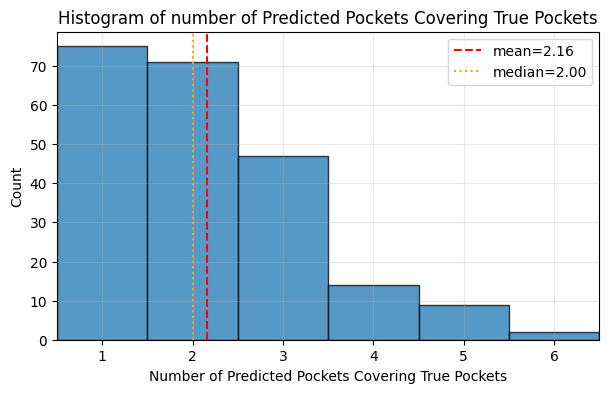

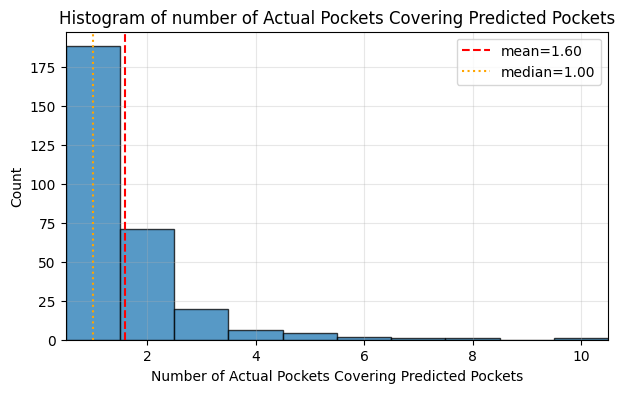

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

number_of_pockets = len(number_of_overlapping_actual_sites_on_predicted_pocket)

mean_br = np.mean(best_residue_overlaps)
median_br = np.median(best_residue_overlaps)
print(f'best_residue_overlap mean={mean_br:.4f}, median={median_br:.4f}')

print(np.sum(np.array(DCCs) < 12) / number_of_pockets, f'({np.sum(np.array(DCCs) < 4) / number_of_pockets})')
print(np.sum(np.array(DCCs_N_plus_K) < 12) / number_of_pockets, f'({np.sum(np.array(DCCs_N_plus_K) < 4) / number_of_pockets})')
print(np.sum(np.array(DCCs_N) < 12) / number_of_pockets, f'({np.sum(np.array(DCCs_N) < 4) / number_of_pockets})')

fig, ax = plt.subplots(figsize=(7, 4))

# Remove zeros
number_of_overlapping_actual_sites_on_predicted_pocket_without_zeros = [i for i in number_of_overlapping_actual_sites_on_predicted_pocket if i != 0]
bins = np.arange(-0.5, max(number_of_overlapping_actual_sites_on_predicted_pocket_without_zeros) + 1.5, 1)
ax.clear()
ax.hist(number_of_overlapping_actual_sites_on_predicted_pocket_without_zeros, bins=bins, color='C0', edgecolor='k', alpha=0.75)
mean_cov = np.mean(number_of_overlapping_actual_sites_on_predicted_pocket_without_zeros)
median_cov = np.median(number_of_overlapping_actual_sites_on_predicted_pocket_without_zeros)
ax.axvline(mean_cov, color='red', linestyle='--', label=f"mean={mean_cov:.2f}")
ax.axvline(median_cov, color='orange', linestyle=':', label=f"median={median_cov:.2f}")
ax.set_title("Histogram of number of Predicted Pockets Covering True Pockets")
ax.set_xlim(0.5, max(number_of_overlapping_actual_sites_on_predicted_pocket_without_zeros) + 0.5)
ax.set_xlabel("Number of Predicted Pockets Covering True Pockets")
ax.set_ylabel("Count")
ax.legend()
ax.grid(alpha=0.3)
plt.show()

fig, ax = plt.subplots(figsize=(7, 4))

# Remove zeros
number_of_overlapping_predictions_on_actual_pocket_without_zeros = [i for i in number_of_overlapping_predictions_on_actual_pocket if i != 0]
bins = np.arange(-0.5, max(number_of_overlapping_predictions_on_actual_pocket_without_zeros) + 1.5, 1)
ax.clear()
ax.hist(number_of_overlapping_predictions_on_actual_pocket_without_zeros, bins=bins, color='C0', edgecolor='k', alpha=0.75)
mean_cov = np.mean(number_of_overlapping_predictions_on_actual_pocket_without_zeros)
median_cov = np.median(number_of_overlapping_predictions_on_actual_pocket_without_zeros)
ax.axvline(mean_cov, color='red', linestyle='--', label=f"mean={mean_cov:.2f}")
ax.axvline(median_cov, color='orange', linestyle=':', label=f"median={median_cov:.2f}")
ax.set_title("Histogram of number of Actual Pockets Covering Predicted Pockets")
ax.set_xlim(0.5, max(number_of_overlapping_predictions_on_actual_pocket_without_zeros) + 0.5)
ax.set_xlabel("Number of Actual Pockets Covering Predicted Pockets")
ax.set_ylabel("Count")
ax.legend()
ax.grid(alpha=0.3)
plt.show()

## Run clustering without smoothing

In [19]:
MODEL_PATH = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/model-enhanced-scPDB.pt'
COORDINATES_DIR = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/ligysis-coordinates'
PRECALCULATED = True
PREDICTIONS_PATH = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/predictions-enhanced-scPDB'
PRECALCULATED_PATH = F'{PREDICTIONS_PATH}/finetuning-without-smoothing'
LIGYSIS_ANNOTATION_PATH = '/home/skrhakv/cryptoshow-analysis/data/E-regular-binding-site-predictor/ligysis_for_pocket_level_evaluation.csv'
DECISION_THRESHOLD = 0.5

model = torch.load(MODEL_PATH, weights_only=False)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

binding_residues, sequences = eval_utils.read_test_binding_residues(data_path=LIGYSIS_ANNOTATION_PATH, pocket_types=['NON_CRYPTIC'])

# debug on subset of 100 proteins
binding_residues = {k: binding_residues[k] for k in list(binding_residues.keys())[:100]}
sequences = {k: sequences[k] for k in list(sequences.keys())[:100]}

predicted_binding_sites = {}
ranks = {}
prediction_scores = {}

K = 2

DCCs_N = []
DCCs_N_plus_K = []
DCCs = []
number_of_overlapping_predictions_on_actual_pocket = []
number_of_overlapping_actual_sites_on_predicted_pocket = []
best_residue_overlaps = []

for i, protein_id in enumerate(sequences.keys()):
    pdb_id, chain_id = protein_id.split('_')
    sequence = sequences[protein_id]
    coordinates_path = f'{COORDINATES_DIR}/{pdb_id}{chain_id}.npy'
    actual_binding_sites = [np.array([int(i.split('_')[1]) for i in pocket]) for pocket in binding_residues[protein_id]]
    
    print(f'Processing {protein_id} ({i+1}/{len(sequences)})...')
    if not PRECALCULATED:
        # finetuned prediction
        probabilities = eval_utils.compute_prediction(
            sequence,
            f'/tmp/skrhakv',
            model,
            tokenizer
        )
    else:
        # load precalculated prediction
        probabilities = np.load(f'{PRECALCULATED_PATH}/{protein_id.replace("_","")}.npy')
    
    prediction_scores[protein_id] = probabilities

    coordinates = np.load(coordinates_path)
    distance_matrix = eval_utils.compute_distance_matrix(coordinates)

    predictions = (probabilities > DECISION_THRESHOLD).astype(float)
    predictions_copy = predictions.copy()

    assert distance_matrix.shape[0] == distance_matrix.shape[1]
    assert distance_matrix.shape[0] == predictions_copy.shape[0]
    
    indices_above_threshold = np.where(predictions_copy > DECISION_THRESHOLD)[0] # this gets residues that are equal to 1
    # no predicted residues - continue
    if len(indices_above_threshold) == 0:
        continue

    # run atom-level clustering and return residue-level pockets
    clusters, cluster_residues, cluster_scores, atom_coords, residue_coords = execute_atom_clustering(
        pdb_id,
        chain_id,
        indices_above_threshold,
        probabilities[indices_above_threshold],
        eps=9
    )

    # none of the residues are on the surface
    if cluster_residues is None:
        continue

    cluster_residues = cryptoshow_utils.map_auth_to_mmcif_numbering_array(
        pdb_id,
        chain_id,
        cluster_residues.values(),
        binding_residues_are_integers=True,
        numbers_only=True
    )[0]

    cluster_order = np.argsort(cluster_scores)[::-1]  # descending order
    N = len(actual_binding_sites)

    selected_clusters_N = cluster_order[:N]
    selected_clusters_N_plus_K = cluster_order[:N+K]

    predicted_centers = {}
    for cluster_label, atom_indices in clusters.items():
        cluster_coords = np.array([atom_coords[atom_id] for atom_id in atom_indices])
        cluster_center = np.mean(cluster_coords, axis=0).get_array()
        predicted_centers[cluster_label] = cluster_center
    
    actual_centers = []

    for pocket in actual_binding_sites:
        pocket_coords = coordinates[pocket]
        pocket_center = np.mean(pocket_coords, axis=0)
        actual_centers.append(pocket_center)
    
    for i, center in enumerate(actual_centers):
        DCC_N = float('inf')
        for j in selected_clusters_N:
            predicted_center = predicted_centers[j]
            distance = np.linalg.norm(center - predicted_center)
            if distance < DCC_N:
                DCC_N = distance
        
        if DCC_N != float('inf'):
            DCCs_N.append(DCC_N)

        DCC_N_plus_K = float('inf')
        for j in selected_clusters_N_plus_K:
            predicted_center = predicted_centers[j]
            distance = np.linalg.norm(center - predicted_center)
            if distance < DCC_N_plus_K:
                DCC_N_plus_K = distance
        
        if DCC_N_plus_K != float('inf'):
            DCCs_N_plus_K.append(DCC_N_plus_K)

        DCC = float('inf')
        for j, predicted_center in predicted_centers.items():
            distance = np.linalg.norm(center - predicted_center)
            if distance < DCC:
                DCC = distance    

        if DCC != float('inf'):
            DCCs.append(DCC)

    for pocket in actual_binding_sites:
        number_of_predicted_pockets = 0
        best_residue_overlap = 0
        for residues in cluster_residues:
            residue_overlap = len(set(pocket).intersection(residues)) / len(pocket)
            if residue_overlap > best_residue_overlap:
                best_residue_overlap = residue_overlap
            if any(residue in pocket for residue in residues):
                number_of_predicted_pockets += 1
        number_of_overlapping_actual_sites_on_predicted_pocket.append(number_of_predicted_pockets)
        if best_residue_overlap > 0:
            best_residue_overlaps.append(best_residue_overlap)

    for residues in cluster_residues:
        number_of_predicted_pockets = 0
        for pocket in actual_binding_sites:
            if any(residue in pocket for residue in residues):
                number_of_predicted_pockets += 1
        number_of_overlapping_predictions_on_actual_pocket.append(number_of_predicted_pockets)



Processing 1a52_A (1/100)...
Processing 1a9w_E (2/100)...
Processing 1aii_A (3/100)...
Processing 1au1_A (4/100)...
Processing 1aue_B (5/100)...
Processing 1b1c_A (6/100)...
Processing 1b50_B (7/100)...
Processing 1b55_B (8/100)...
Processing 1b6c_F (9/100)...
Processing 1b9o_A (10/100)...
Processing 1bbo_A (11/100)...
Processing 1bci_A (12/100)...
Processing 1bf9_A (13/100)...
Processing 1bhi_A (14/100)...
Processing 1bld_A (15/100)...
Processing 1blx_A (16/100)...
Processing 1bmo_A (17/100)...
Processing 1bnl_A (18/100)...
Processing 1boy_A (19/100)...
Processing 1bp5_A (20/100)...
Processing 1buv_M (21/100)...
Processing 1byg_A (22/100)...
Processing 1bzs_A (23/100)...
Processing 1c07_A (24/100)...
Processing 1c4z_A (25/100)...
Processing 1c9y_A (26/100)...
Processing 1cb6_A (27/100)...
Processing 1cjy_B (28/100)...
Processing 1cm8_A (29/100)...
Processing 1cr8_A (30/100)...
Processing 1cws_A (31/100)...
Processing 1cx8_C (32/100)...
Processing 1cza_N (33/100)...
Processing 1czv_A (

best_residue_overlap mean=0.5634, median=0.5436
0.7482517482517482 (0.23076923076923078)
0.7377622377622378 (0.22727272727272727)
0.6783216783216783 (0.2097902097902098)


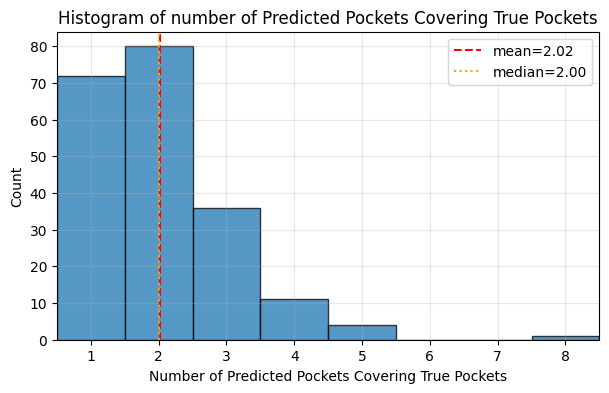

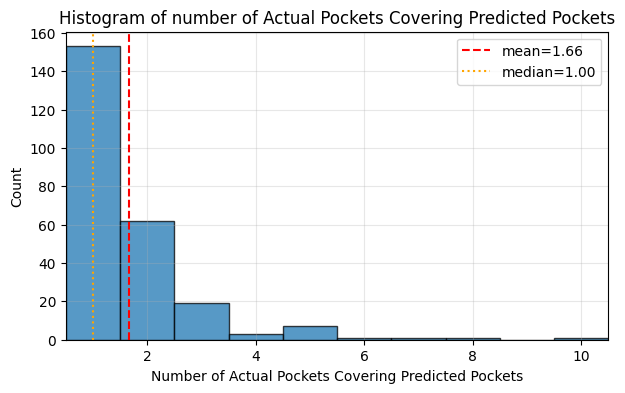

In [21]:
import numpy as np
import matplotlib.pyplot as plt

number_of_pockets = len(number_of_overlapping_actual_sites_on_predicted_pocket)

mean_br = np.mean(best_residue_overlaps)
median_br = np.median(best_residue_overlaps)
print(f'best_residue_overlap mean={mean_br:.4f}, median={median_br:.4f}')
print(np.sum(np.array(DCCs) < 12) / number_of_pockets, f'({np.sum(np.array(DCCs) < 4) / number_of_pockets})')
print(np.sum(np.array(DCCs_N_plus_K) < 12) / number_of_pockets, f'({np.sum(np.array(DCCs_N_plus_K) < 4) / number_of_pockets})')
print(np.sum(np.array(DCCs_N) < 12) / number_of_pockets, f'({np.sum(np.array(DCCs_N) < 4) / number_of_pockets})')

fig, ax = plt.subplots(figsize=(7, 4))

# Remove zeros
number_of_overlapping_actual_sites_on_predicted_pocket_without_zeros = [i for i in number_of_overlapping_actual_sites_on_predicted_pocket if i != 0]
bins = np.arange(-0.5, max(number_of_overlapping_actual_sites_on_predicted_pocket_without_zeros) + 1.5, 1)
ax.clear()
ax.hist(number_of_overlapping_actual_sites_on_predicted_pocket_without_zeros, bins=bins, color='C0', edgecolor='k', alpha=0.75)
mean_cov = np.mean(number_of_overlapping_actual_sites_on_predicted_pocket_without_zeros)
median_cov = np.median(number_of_overlapping_actual_sites_on_predicted_pocket_without_zeros)
ax.axvline(mean_cov, color='red', linestyle='--', label=f"mean={mean_cov:.2f}")
ax.axvline(median_cov, color='orange', linestyle=':', label=f"median={median_cov:.2f}")
ax.set_title("Histogram of number of Predicted Pockets Covering True Pockets")
ax.set_xlim(0.5, max(number_of_overlapping_actual_sites_on_predicted_pocket_without_zeros) + 0.5)
ax.set_xlabel("Number of Predicted Pockets Covering True Pockets")
ax.set_ylabel("Count")
ax.legend()
ax.grid(alpha=0.3)
plt.show()

fig, ax = plt.subplots(figsize=(7, 4))

# Remove zeros
number_of_overlapping_predictions_on_actual_pocket_without_zeros = [i for i in number_of_overlapping_predictions_on_actual_pocket if i != 0]
bins = np.arange(-0.5, max(number_of_overlapping_predictions_on_actual_pocket_without_zeros) + 1.5, 1)
ax.clear()
ax.hist(number_of_overlapping_predictions_on_actual_pocket_without_zeros, bins=bins, color='C0', edgecolor='k', alpha=0.75)
mean_cov = np.mean(number_of_overlapping_predictions_on_actual_pocket_without_zeros)
median_cov = np.median(number_of_overlapping_predictions_on_actual_pocket_without_zeros)
ax.axvline(mean_cov, color='red', linestyle='--', label=f"mean={mean_cov:.2f}")
ax.axvline(median_cov, color='orange', linestyle=':', label=f"median={median_cov:.2f}")
ax.set_title("Histogram of number of Actual Pockets Covering Predicted Pockets")
ax.set_xlim(0.5, max(number_of_overlapping_predictions_on_actual_pocket_without_zeros) + 0.5)
ax.set_xlabel("Number of Actual Pockets Covering Predicted Pockets")
ax.set_ylabel("Count")
ax.legend()
ax.grid(alpha=0.3)
plt.show()



In [ ]:
# with smoothing (distance=10), meanshift eps=10
# 0.7307692307692307 (0.18181818181818182)
# 0.7237762237762237 (0.17832167832167833)
# 0.6783216783216783 (0.17132867132867133)

# with smoothing (distance=15), meanshift eps=10
# 0.7552447552447552 (0.19230769230769232)
# 0.7307692307692307 (0.17832167832167833)
# 0.6888111888111889 (0.16783216783216784)

# without smoothing (no distance), meanshift eps=10
# 0.7237762237762237 (0.2062937062937063)   -3
# 0.7202797202797203 (0.2062937062937063)   -1
# 0.6853146853146853 (0.1958041958041958)   -0

# with smoothing, eps=9:
# best_residue_overlap mean=0.5625, median=0.5556
# 0.7937062937062938 (0.2097902097902098)
# 0.7622377622377622 (0.1993006993006993)
# 0.6853146853146853 (0.18181818181818182)

# without smoothing, eps=9: 
# best_residue_overlap mean=0.5634, median=0.5436
# 0.7482517482517482 (0.23076923076923078)  -5
# 0.7377622377622378 (0.22727272727272727)  -3
# 0.6783216783216783 (0.2097902097902098)   -1